# Introduction
## Background
In this final project I am going to discuss, analyze the data of restraunts in NEWYOKCITY, the aim of this project eventually is going to be segmenting the restraunts in NYC with corresponding traditional cuisines


## Problem 
- Do cluster analysis for all food related venues and find optimal locaation(s) for establishing new restraunt inn NYC ,using Foursquare api

I am taking the newyork city data set as given from assignment and making a model to cluster the data in such a way that we will be goin to have perfect idea on how different type restraunts are functioning well in their repective surroundings
so data of neighbours is taken from web and respectvive restraunts data is scraped using FOURSQUARE's places,venue api

## target audience/stakeholders
for a person who wants to open restraunt in NYC this project will be helpful in choosing place for his type of restraunt. Or this can also be focused for people who are planning for online food delivery startups. they can use this for opening new branches in optimal location(s) near to major restraunts 

# Data
## description of the data
source :  https://geo.nyu.edu/catalog/nyu_2451_34572
NYC has many neighbourhoods(nothing but major landmarks). the above source provide many such major neighbourhoods in NYC
here comes https://foursquare.com/ we use this for getting all venues within provided radius of all neighbouhoods
- we got 305 neighbours
- venues are taken from foursquare API
- This data may include offices, universities, crowded areas like theaters and parks in NYC
- data will have latitudes and longitues of such workplaces and we'll find optimum location in various clustered regions

## so data is
Country/City: NYC
Goal: Open a restaurant for  workers in weekdays
So, I will cross data from working days, and localisations.

### I will use the following API:
Foursquare API: to find restaurant/venues
### the neighbourhood data looks like this 
![neighbourhood](https://user-images.githubusercontent.com/68729609/125493624-22ae41c8-5e49-4ff1-bbe3-dcbf6f8397ee.png)
### single venue given by foursquare api would look like this
![venue from foursquare ](https://user-images.githubusercontent.com/68729609/125494737-a03f25ab-a626-43f0-b3e0-0b206050a5ca.png)

# methodology

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

#### data
is mentioned in introduction , taken form those urls and now we'll parse

In [4]:
import wget
import os

if os.path.exists('newyork_data.json'):
    os.remove('newyork_data.json')

wget.download('https://cocl.us/new_york_dataset/newyork_data.json')

print('\nData downloaded!')


Data downloaded!


In [5]:
# open & load downloaded file, print its type
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
print ("newyork_data key and value's length are: ") 
for key, value in newyork_data.items(): 
    print (key, len(str(value)))

newyork_data key and value's length are: 
type 17
totalFeatures 3
features 124743
crs 70
bbox 74


In [6]:
neighborhoods_data = newyork_data['features']
pprint(neighborhoods_data[305])

{'geometry': {'coordinates': [-74.08173992211962, 40.61731079252983],
              'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.306',
 'properties': {'annoangle': 0.0,
                'annoline1': 'Fox',
                'annoline2': 'Hills',
                'annoline3': None,
                'bbox': [-74.08173992211962,
                         40.61731079252983,
                         -74.08173992211962,
                         40.61731079252983],
                'borough': 'Staten Island',
                'name': 'Fox Hills',
                'stacked': 2},
 'type': 'Feature'}


this is the info of neighbourhoods,  we need only few important columns like borough, neighbourhoods and lat,lon

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [8]:
#add data to the respective columns
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [11]:
#we need  latitudes and longitudes of each neighbourhoods and then use foursquare api
address = 'New York City, NY'
location = None

# define an instance of the geocoder -> ny_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [13]:
#use folium to plot those neighbourhoods

In [14]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [15]:
CLIENT_ID= 'ZVK5YKH5XQKTNS0OFJ552U5C2S1A51RBH3NPCFKIXW3UPZAC'
CLIENT_SECRET='DDZFOTPDNSIPP1420QFCSVL2YCV2Z1PBUUUNKVJW3ZYOFWX5'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZVK5YKH5XQKTNS0OFJ552U5C2S1A51RBH3NPCFKIXW3UPZAC
CLIENT_SECRET:DDZFOTPDNSIPP1420QFCSVL2YCV2Z1PBUUUNKVJW3ZYOFWX5


# Foursquare API 
we use foursquare api for fetching all neary venus of each neighbourhood data

In [16]:

url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [17]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 16373


In [18]:
category_list = category_results['response']['categories']

In [19]:
len(category_list)

10

In [20]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


In [21]:
#so this are the ids for particular type of venues, choose food and proceed
#so creating a function to return a dictionary

# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [22]:
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

In [24]:
neighborhoods.loc[:, 'Neighborhood']

0                      Wakefield
1                     Co-op City
2                    Eastchester
3                      Fieldston
4                      Riverdale
5                    Kingsbridge
6                    Marble Hill
7                       Woodlawn
8                        Norwood
9                 Williamsbridge
10                    Baychester
11                Pelham Parkway
12                   City Island
13                  Bedford Park
14            University Heights
15                Morris Heights
16                       Fordham
17                  East Tremont
18                    West Farms
19                  High  Bridge
20                       Melrose
21                    Mott Haven
22                   Port Morris
23                      Longwood
24                   Hunts Point
25                    Morrisania
26                     Soundview
27                  Clason Point
28                   Throgs Neck
29                  Country Club
30        

In [25]:

neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


Now, let's get the Food that is in Wakefield within a radius of 500 meters.
First, let's create the GET request URL to search for Venue with requested Category ID

In [29]:
LIMIT = 3 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=ZVK5YKH5XQKTNS0OFJ552U5C2S1A51RBH3NPCFKIXW3UPZAC&client_secret=DDZFOTPDNSIPP1420QFCSVL2YCV2Z1PBUUUNKVJW3ZYOFWX5&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=3'

In [30]:
#sending GET request
results = requests.get(url).json()

In [31]:
results['response']['venues']

[{'id': '4c537892fd2ea593cb077a28',
  'name': 'Lollipops Gelato',
  'location': {'address': '4120 Baychester Ave',
   'crossStreet': 'Edenwald & Bussing Ave',
   'lat': 40.894123150205274,
   'lng': -73.84589162362325,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.894123150205274,
     'lng': -73.84589162362325},
    {'label': 'entrance', 'lat': 40.89362, 'lng': -73.843737}],
   'distance': 127,
   'postalCode': '10466',
   'cc': 'US',
   'city': 'Bronx',
   'state': 'NY',
   'country': 'United States',
   'formattedAddress': ['4120 Baychester Ave (Edenwald & Bussing Ave)',
    'Bronx, NY 10466',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1d0941735',
    'name': 'Dessert Shop',
    'pluralName': 'Dessert Shops',
    'shortName': 'Desserts',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dessert_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1626281363',
  'hasPerk': False},
 {'id': '4c783cef3badb1f7e4244b54',
  

In [32]:
#lets create nyc_venues

In [33]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

In [34]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

In [35]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('nyc_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    nyc_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


to know how many venues are there in neighbourhood

In [42]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
k = nyc_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)
k   

There are 202 uniques categories.


Venue Category
Deli / Bodega                               1106
Pizza Place                                 1041
Coffee Shop                                  819
Chinese Restaurant                           626
Donut Shop                                   617
Bakery                                       582
Italian Restaurant                           548
Fast Food Restaurant                         514
Café                                         437
Caribbean Restaurant                         351
American Restaurant                          348
Mexican Restaurant                           340
Bagel Shop                                   340
Ice Cream Shop                               339
Fried Chicken Joint                          299
Sandwich Place                               247
Restaurant                                   245
Diner                                        236
Seafood Restaurant                           199
Food Truck                                   187
Burge

In [48]:
#no need all other shops other thsn restaurants so
restaurants =[]
for i in k.index:
    if 'Restaurant' in i or 'restaurant' in i:
        restaurants.append(i)
print(restaurants)

['Chinese Restaurant', 'Italian Restaurant', 'Fast Food Restaurant', 'Caribbean Restaurant', 'American Restaurant', 'Mexican Restaurant', 'Restaurant', 'Seafood Restaurant', 'Japanese Restaurant', 'Sushi Restaurant', 'Spanish Restaurant', 'Asian Restaurant', 'Thai Restaurant', 'Latin American Restaurant', 'Korean Restaurant', 'Indian Restaurant', 'New American Restaurant', 'French Restaurant', 'Greek Restaurant', 'Middle Eastern Restaurant', 'Vietnamese Restaurant', 'Southern / Soul Food Restaurant', 'Vegetarian / Vegan Restaurant', 'Mediterranean Restaurant', 'Ramen Restaurant', 'Peruvian Restaurant', 'Halal Restaurant', 'South American Restaurant', 'African Restaurant', 'Dim Sum Restaurant', 'Eastern European Restaurant', 'Comfort Food Restaurant', 'Empanada Restaurant', 'Filipino Restaurant', 'German Restaurant', 'Turkish Restaurant', 'Tapas Restaurant', 'Russian Restaurant', 'Cantonese Restaurant', 'Dumpling Restaurant', 'Sri Lankan Restaurant', 'Cuban Restaurant', 'Shanghai Restau

In [50]:

nyc_venues = nyc_venues[nyc_venues['Venue Category'].isin(restaurants)].reset_index()
nyc_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,3,Wakefield,40.894705,-73.847201,Burger King,40.895540,-73.856460,Fast Food Restaurant
1,4,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
2,9,Wakefield,40.894705,-73.847201,Golden Krust Caribbean Restaurant,40.903773,-73.850051,Caribbean Restaurant
3,10,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant,40.898083,-73.850259,Caribbean Restaurant
4,11,Wakefield,40.894705,-73.847201,Paula's Soul Cafe,40.893328,-73.855142,Southern / Soul Food Restaurant


In [51]:
#finally we got required data of restaurants in corresponding neighbourhood

<AxesSubplot:xlabel='Neighborhood'>

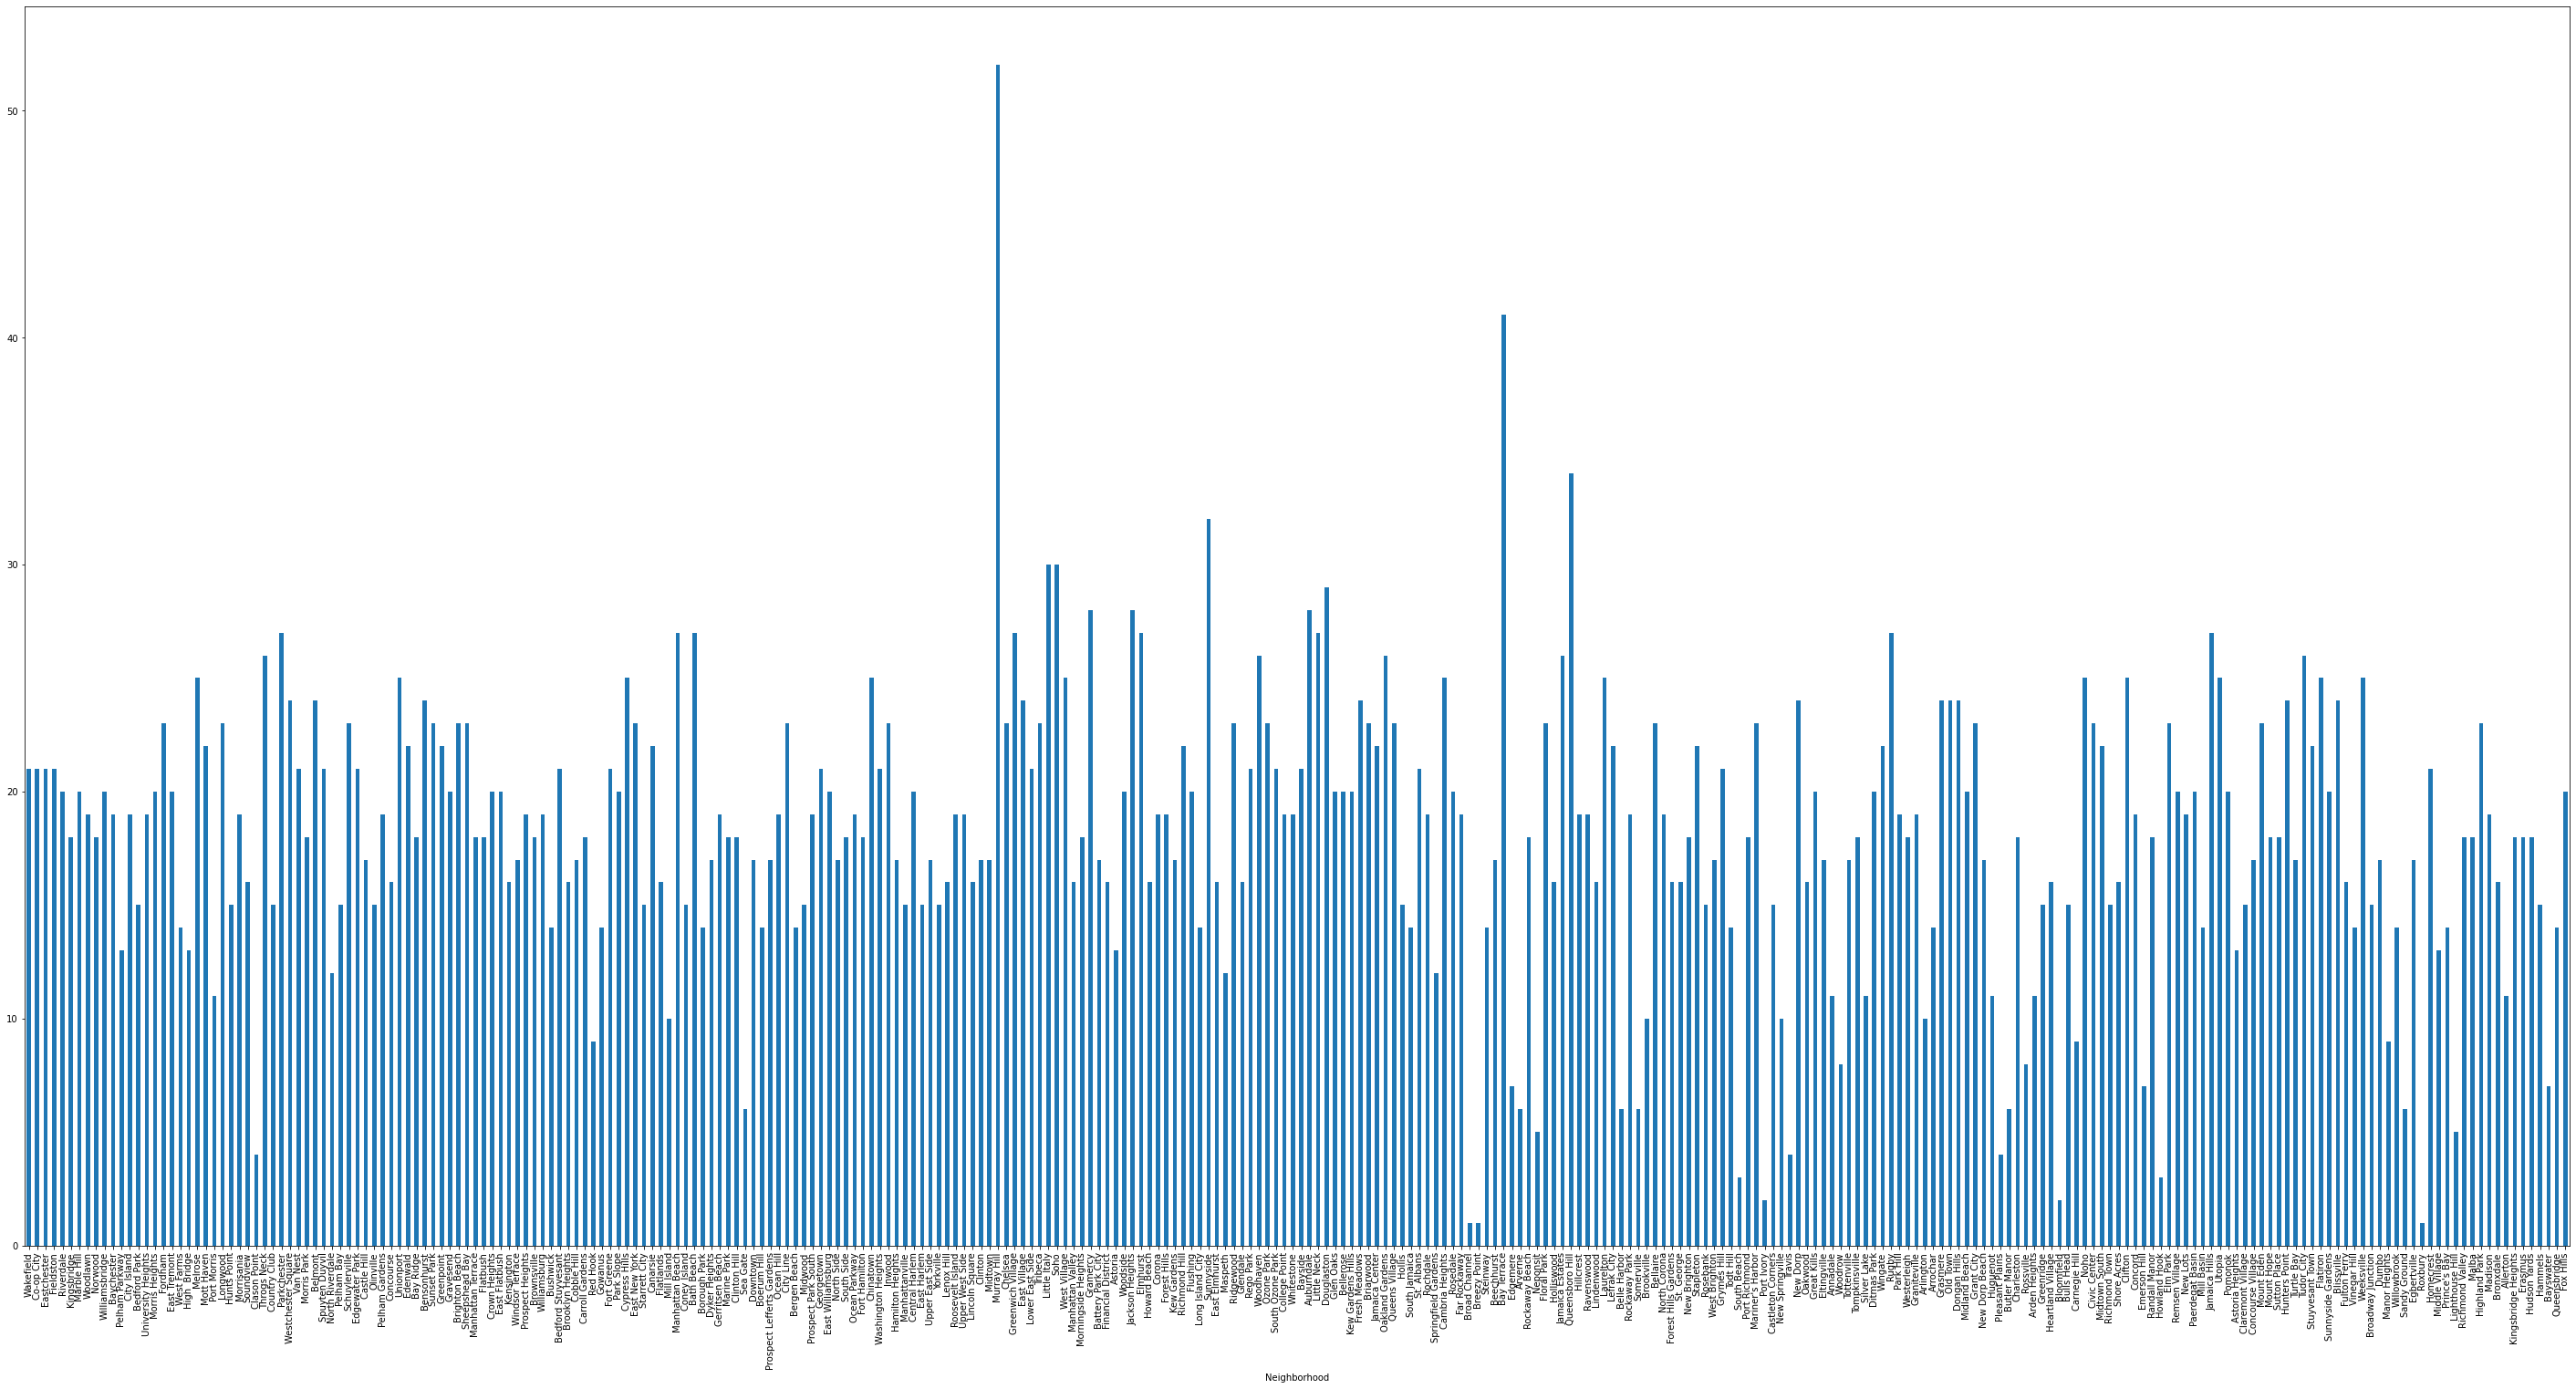

In [52]:

df = nyc_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(50,25))

In [53]:
#lets drop all neighbourhoods which have less than 10 counts
#because many have more than 10, if a place doesn;t hvae more than atleast 10 means there must be many defets like more tax or less customers


<AxesSubplot:xlabel='Neighborhood'>

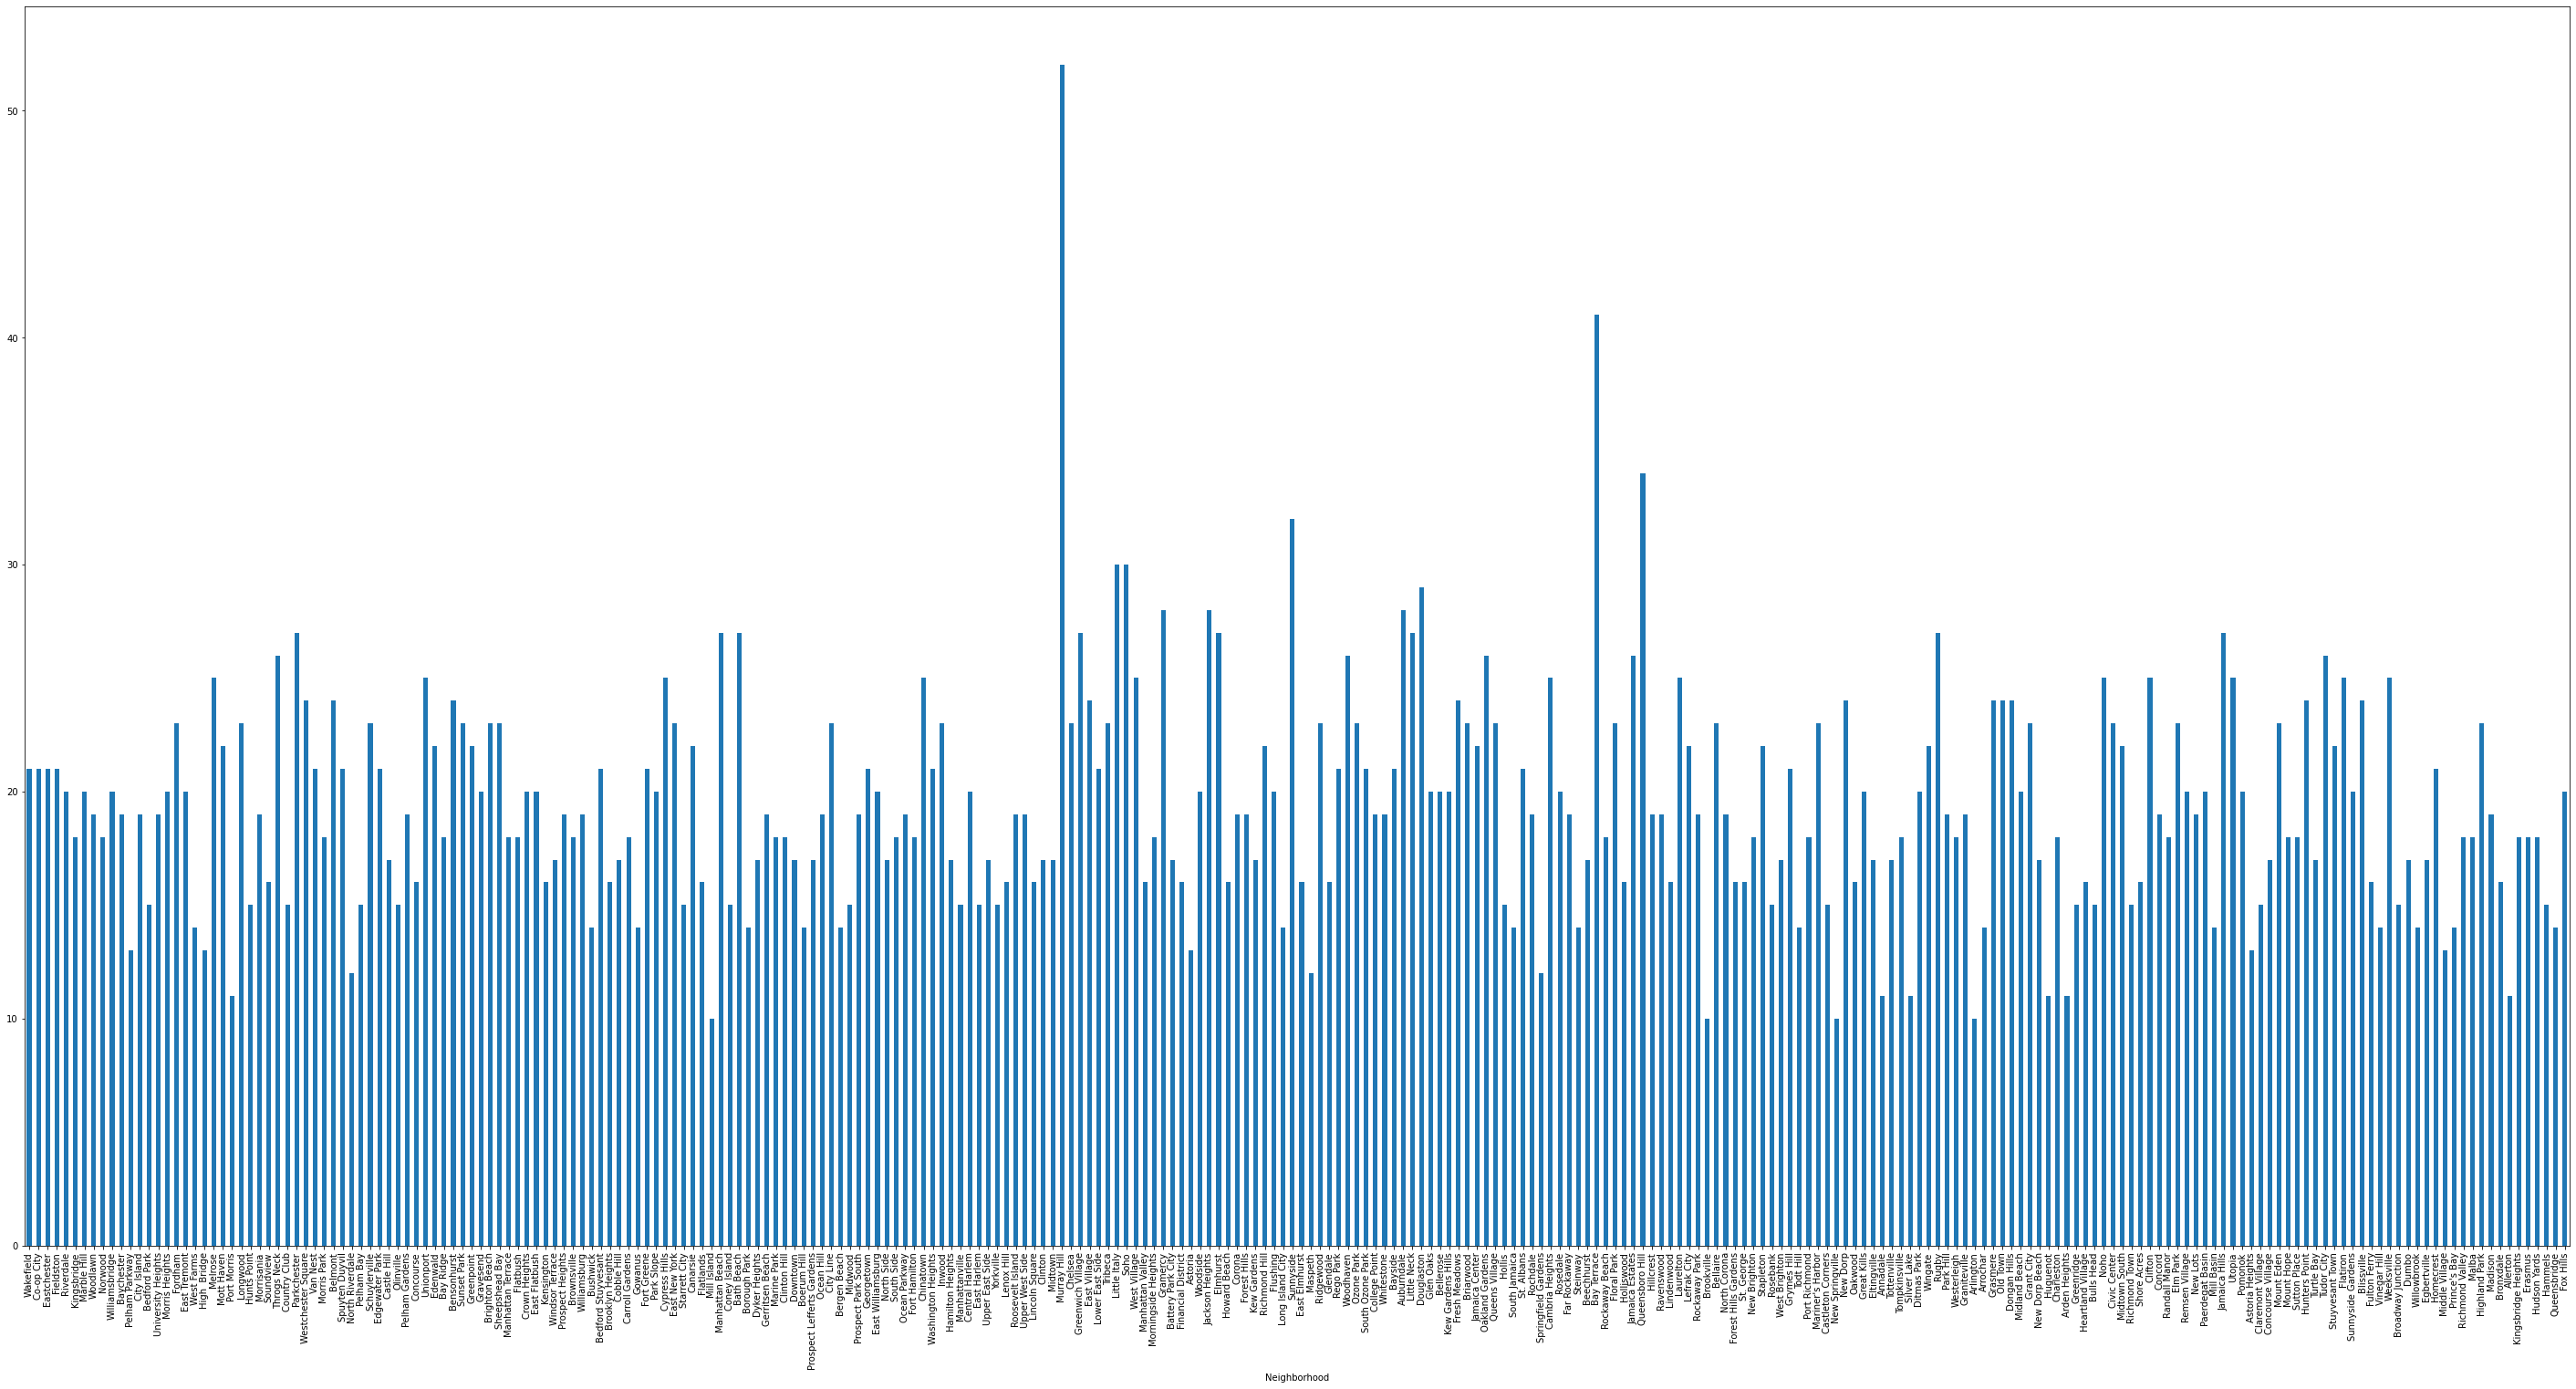

In [55]:
df = df[df >= 10]
df.plot.bar(figsize=(50,25))

In [56]:
nyc_venues_top = nyc_venues[nyc_venues['Neighborhood'].isin(df.index.tolist())]
nyc_venues_top.head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,3,Wakefield,40.894705,-73.847201,Burger King,40.895540,-73.856460,Fast Food Restaurant
1,4,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
2,9,Wakefield,40.894705,-73.847201,Golden Krust Caribbean Restaurant,40.903773,-73.850051,Caribbean Restaurant
3,10,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant,40.898083,-73.850259,Caribbean Restaurant
4,11,Wakefield,40.894705,-73.847201,Paula's Soul Cafe,40.893328,-73.855142,Southern / Soul Food Restaurant


In [58]:
#now we got some decent and clean data let's check how mnay unique values are there

print('There are {} uniques venues.'.format(len(nyc_venues_top['Venue'].unique())))

There are 2749 uniques venues.


In [60]:
#one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = nyc_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
nyc_onehot = nyc_onehot.reindex(columns = fixed_columns)

print(nyc_onehot.shape)
nyc_onehot.head()

(5369, 97)


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Armenian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Bangladeshi Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Puerto Rican Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salvadoran Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
#average it out by grouping neighbours and find top 10 in each neighbouhood then we will analyse model
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
print(nyc_grouped.shape)
nyc_grouped.head()

(276, 97)


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Armenian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Bangladeshi Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Puerto Rican Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salvadoran Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant
0,Allerton,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.545455,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.181818,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.090909,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.200000,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.100000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214286,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [63]:
#for top 10 restraunts
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
#taken this code from given template in course
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Eastern European Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant,Salvadoran Restaurant,Russian Restaurant
1,Annadale,Italian Restaurant,American Restaurant,Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant
2,Arden Heights,American Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant,Chinese Restaurant,Mexican Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant
3,Arlington,American Restaurant,Fast Food Restaurant,Peruvian Restaurant,Chinese Restaurant,Spanish Restaurant,Asian Restaurant,Caribbean Restaurant,Polish Restaurant,Shabu-Shabu Restaurant,Seafood Restaurant
4,Arrochar,Italian Restaurant,Restaurant,Chinese Restaurant,Polish Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Afghan Restaurant,Seafood Restaurant,Scandinavian Restaurant


<ipython-input-73-088417de6ca8>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)


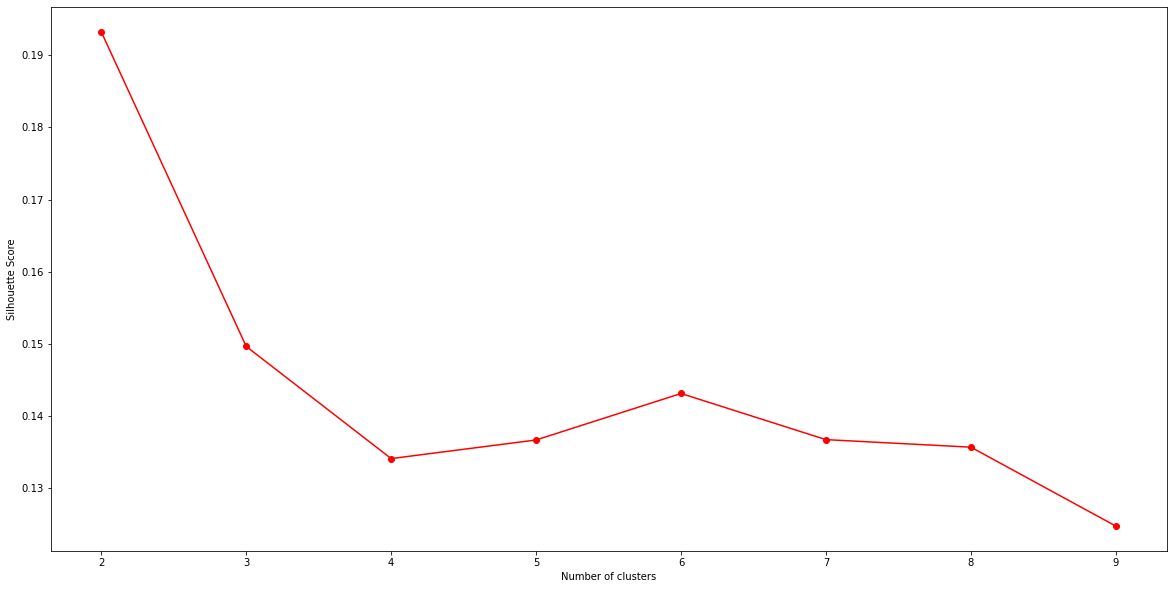

In [73]:
#okay, how do we know K,  we have silhouette score method and elbow method let's apply both to check best k
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(nyc_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(nyc_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

C:\Users\charan varma\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


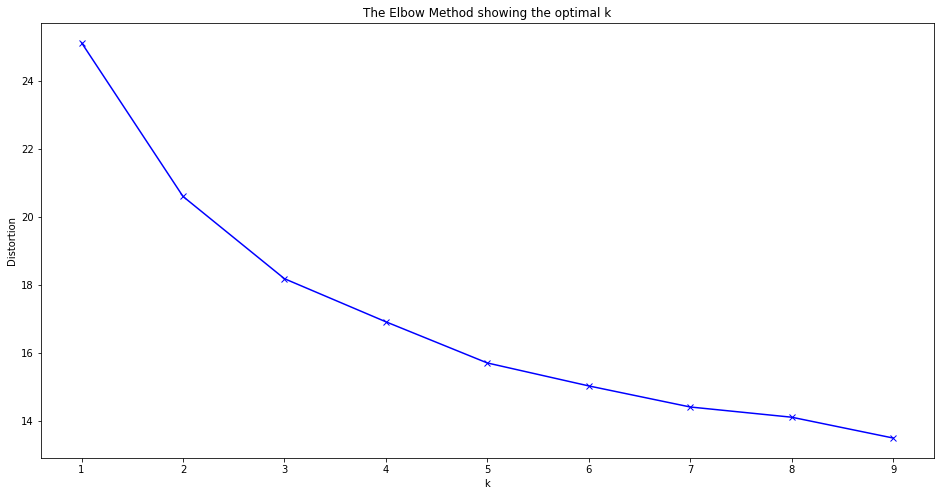

In [74]:
#elbow method
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(nyc_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

`k =4`
`k=6`
`k=8(elbow)`
might gives some better results
lets check

In [75]:

# select best number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 2, 7, 6, 2, 5, 2, 0, 7, 5])

In [80]:
#got them!!!lets also add the latitudes and longitudes of each neighbours 
# add clustering labels
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
nyc_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
nyc_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
0,4,Allerton,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Eastern European Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant,Salvadoran Restaurant,Russian Restaurant,Bronx,40.865788,-73.859319
1,2,Annadale,Italian Restaurant,American Restaurant,Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant,Staten Island,40.538114,-74.178549
2,7,Arden Heights,American Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant,Chinese Restaurant,Mexican Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant,Staten Island,40.549286,-74.185887
3,6,Arlington,American Restaurant,Fast Food Restaurant,Peruvian Restaurant,Chinese Restaurant,Spanish Restaurant,Asian Restaurant,Caribbean Restaurant,Polish Restaurant,Shabu-Shabu Restaurant,Seafood Restaurant,Staten Island,40.635325,-74.165104
4,2,Arrochar,Italian Restaurant,Restaurant,Chinese Restaurant,Polish Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Afghan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Staten Island,40.596313,-74.067124


In [79]:

neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,Allerton,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Eastern European Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant,Salvadoran Restaurant,Russian Restaurant
1,2,Annadale,Italian Restaurant,American Restaurant,Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant
2,7,Arden Heights,American Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant,Chinese Restaurant,Mexican Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant
3,6,Arlington,American Restaurant,Fast Food Restaurant,Peruvian Restaurant,Chinese Restaurant,Spanish Restaurant,Asian Restaurant,Caribbean Restaurant,Polish Restaurant,Shabu-Shabu Restaurant,Seafood Restaurant
4,2,Arrochar,Italian Restaurant,Restaurant,Chinese Restaurant,Polish Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Afghan Restaurant,Seafood Restaurant,Scandinavian Restaurant


In [81]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
#we got clusted the venues, now lets examine each cluster


In [97]:

required_column_indices = [2,3,7]
required_column = [list(nyc_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]
def cluster(n):
    return nyc_merged.loc[nyc_merged['Cluster Labels'] == n, nyc_merged.columns[[0] + list(range(4, nyc_merged.shape[1]))]]
def req_col(cluster):
    for col in required_column:
        print(cluster[col].value_counts(ascending = False))
        print("---------------------------------------------")

In [104]:
#cluster1
cluster_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Auburndale,Korean Restaurant,Greek Restaurant,Chinese Restaurant,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Cantonese Restaurant,Seafood Restaurant,Modern Greek Restaurant,Asian Restaurant
13,Bayside,Korean Restaurant,Mexican Restaurant,Greek Restaurant,Fast Food Restaurant,Chinese Restaurant,Cajun / Creole Restaurant,Mediterranean Restaurant,Taiwanese Restaurant,Cuban Restaurant,Thai Restaurant
86,Flatiron,Korean Restaurant,Italian Restaurant,Japanese Restaurant,Thai Restaurant,New American Restaurant,French Restaurant,American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant
103,Gramercy,Korean Restaurant,American Restaurant,Japanese Restaurant,Thai Restaurant,New American Restaurant,Italian Restaurant,Mexican Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Ramen Restaurant
160,Midtown,Korean Restaurant,American Restaurant,Restaurant,French Restaurant,Empanada Restaurant,Sushi Restaurant,Italian Restaurant,Halal Restaurant,Comfort Food Restaurant,Ramen Restaurant


In [105]:

for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Korean Restaurant    9
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
American Restaurant    4
Japanese Restaurant    2
Greek Restaurant       1
Mexican Restaurant     1
Italian Restaurant     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Sushi Restaurant             2
Italian Restaurant           2
Ramen Restaurant             2
Cajun / Creole Restaurant    1
French Restaurant            1
Australian Restaurant        1
Name: 6th Most Common Venue, dtype: int64
---------------------------------------------


In [106]:
cluster_1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Bay Ridge,American Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Yemeni Restaurant,Chinese Restaurant,New American Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant,German Restaurant
12,Baychester,Caribbean Restaurant,Seafood Restaurant,Japanese Restaurant,Spanish Restaurant,Restaurant,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,Mexican Restaurant,American Restaurant
22,Blissville,Fast Food Restaurant,Chinese Restaurant,South American Restaurant,Mexican Restaurant,Italian Restaurant,Thai Restaurant,Seafood Restaurant,American Restaurant,Latin American Restaurant,Asian Restaurant
37,Castle Hill,Spanish Restaurant,American Restaurant,Latin American Restaurant,Southern / Soul Food Restaurant,Caribbean Restaurant,Japanese Restaurant,Italian Restaurant,Cuban Restaurant,Comfort Food Restaurant,Mexican Restaurant
47,Clifton,Mexican Restaurant,Chinese Restaurant,Italian Restaurant,Spanish Restaurant,African Restaurant,Restaurant,Asian Restaurant,Seafood Restaurant,Eastern European Restaurant,Cajun / Creole Restaurant


In [107]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fast Food Restaurant         16
Mexican Restaurant           11
American Restaurant           4
Caribbean Restaurant          4
Chinese Restaurant            2
Latin American Restaurant     2
Middle Eastern Restaurant     2
Restaurant                    2
Spanish Restaurant            1
Italian Restaurant            1
Seafood Restaurant            1
Asian Restaurant              1
Sri Lankan Restaurant         1
New American Restaurant       1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Mexican Restaurant           13
Fast Food Restaurant          9
Chinese Restaurant            5
American Restaurant           5
Seafood Restaurant            2
Italian Restaurant            2
Caribbean Restaurant          2
Asian Restaurant              2
Spanish Restaurant            2
South American Restaurant     1
Japanese Restaurant           1
Indian Restaurant             1
Mediterranean Restaurant      1
Restaurant                    1
Arepa Restaurant

In [108]:
cluster_2 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Annadale,Italian Restaurant,American Restaurant,Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant
4,Arrochar,Italian Restaurant,Restaurant,Chinese Restaurant,Polish Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Afghan Restaurant,Seafood Restaurant,Scandinavian Restaurant
6,Astoria Heights,Greek Restaurant,Italian Restaurant,Chinese Restaurant,French Restaurant,Sushi Restaurant,Restaurant,Indian Restaurant,Falafel Restaurant,Afghan Restaurant,Puerto Rican Restaurant
11,Bay Terrace,Italian Restaurant,Asian Restaurant,American Restaurant,Mexican Restaurant,Chinese Restaurant,Japanese Restaurant,Spanish Restaurant,Restaurant,Fast Food Restaurant,Gluten-free Restaurant
11,Bay Terrace,Italian Restaurant,Asian Restaurant,American Restaurant,Mexican Restaurant,Chinese Restaurant,Japanese Restaurant,Spanish Restaurant,Restaurant,Fast Food Restaurant,Gluten-free Restaurant


In [109]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant      32
Chinese Restaurant       4
Greek Restaurant         1
Fast Food Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Mexican Restaurant           7
Fast Food Restaurant         6
Chinese Restaurant           6
Restaurant                   4
American Restaurant          3
Asian Restaurant             3
Italian Restaurant           2
Sushi Restaurant             1
Latin American Restaurant    1
New American Restaurant      1
Caribbean Restaurant         1
Japanese Restaurant          1
Mediterranean Restaurant     1
Greek Restaurant             1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Restaurant                     5
Mexican Restaurant             4
Chinese Restaurant             3
Japanese Restaurant            3
Fast Food Restaurant           3
Spanish Restaurant             3
Eastern European Restaurant    2
Peruvian Restaurant            1
Comfort Food Resta

In [110]:
cluster_3 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Brookville,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,New American Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant,Salvadoran Restaurant,Russian Restaurant
31,Brownsville,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Seafood Restaurant,Spanish Restaurant,Restaurant,Hunan Restaurant,American Restaurant,Moroccan Restaurant,New American Restaurant
34,Cambria Heights,Caribbean Restaurant,Restaurant,Chinese Restaurant,Latin American Restaurant,African Restaurant,Fast Food Restaurant,Seafood Restaurant,Pakistani Restaurant,Scandinavian Restaurant,Salvadoran Restaurant
35,Canarsie,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Restaurant,African Restaurant,Mexican Restaurant,Asian Restaurant,Polish Restaurant,Shabu-Shabu Restaurant,Seafood Restaurant
59,Crown Heights,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Fast Food Restaurant,Mexican Restaurant,Chinese Restaurant,Tapas Restaurant,Cajun / Creole Restaurant,Sushi Restaurant,French Restaurant


In [111]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Caribbean Restaurant    26
Chinese Restaurant       1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant             13
Chinese Restaurant                9
Vegetarian / Vegan Restaurant     2
Restaurant                        1
Mexican Restaurant                1
Caribbean Restaurant              1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Asian Restaurant                   7
Restaurant                         3
Cajun / Creole Restaurant          2
Spanish Restaurant                 2
Vegetarian / Vegan Restaurant      2
Polish Restaurant                  1
Fast Food Restaurant               1
Mexican Restaurant                 1
Chinese Restaurant                 1
Halal Restaurant                   1
Southern / Soul Food Restaurant    1
Comfort Food Restaurant            1
Colombian Restaurant               1
New American Restaurant            1
Latin American Restaurant          1

In [112]:

cluster_4 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Eastern European Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant,Salvadoran Restaurant,Russian Restaurant
14,Bedford Park,Chinese Restaurant,Fast Food Restaurant,Mexican Restaurant,Empanada Restaurant,Southern / Soul Food Restaurant,New American Restaurant,Italian Restaurant,Caribbean Restaurant,Shabu-Shabu Restaurant,Seafood Restaurant
17,Bellaire,Chinese Restaurant,Halal Restaurant,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,American Restaurant,Spanish Restaurant,Greek Restaurant,Sushi Restaurant,Restaurant
18,Bellerose,Indian Restaurant,Chinese Restaurant,Halal Restaurant,African Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Latin American Restaurant,Mexican Restaurant
20,Bensonhurst,Chinese Restaurant,Asian Restaurant,Sushi Restaurant,Fast Food Restaurant,Dim Sum Restaurant,Cantonese Restaurant,Italian Restaurant,Thai Restaurant,Mexican Restaurant,Vietnamese Restaurant


In [113]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Chinese Restaurant      34
Indian Restaurant        3
Thai Restaurant          2
Caribbean Restaurant     2
American Restaurant      2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant       8
American Restaurant      8
Mexican Restaurant       6
Caribbean Restaurant     3
Fast Food Restaurant     3
Italian Restaurant       2
Thai Restaurant          2
Indian Restaurant        1
Cantonese Restaurant     1
Restaurant               1
Korean Restaurant        1
Hotpot Restaurant        1
Sri Lankan Restaurant    1
Spanish Restaurant       1
Sushi Restaurant         1
Asian Restaurant         1
Halal Restaurant         1
Seafood Restaurant       1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Mexican Restaurant                 3
Empanada Restaurant                3
Vegetarian / Vegan Restaurant      3
Sushi Restaurant                   3
Sri Lankan Restaurant              2
Fast Food Restaura

In [114]:
cluster_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Astoria,Greek Restaurant,American Restaurant,Mexican Restaurant,Ramen Restaurant,Italian Restaurant,Turkish Restaurant,Sushi Restaurant,Cajun / Creole Restaurant,Thai Restaurant,Afghan Restaurant
9,Battery Park City,Italian Restaurant,Seafood Restaurant,New American Restaurant,Mexican Restaurant,Japanese Restaurant,French Restaurant,Restaurant,Indian Restaurant,Fast Food Restaurant,Cajun / Creole Restaurant
15,Bedford Stuyvesant,Italian Restaurant,French Restaurant,Fast Food Restaurant,Southern / Soul Food Restaurant,Caribbean Restaurant,New American Restaurant,Japanese Restaurant,Ramen Restaurant,Seafood Restaurant,Filipino Restaurant
23,Boerum Hill,French Restaurant,Mexican Restaurant,Vietnamese Restaurant,German Restaurant,Italian Restaurant,New American Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,American Restaurant
29,Brooklyn Heights,American Restaurant,French Restaurant,Seafood Restaurant,Chinese Restaurant,Vietnamese Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Spanish Restaurant,Italian Restaurant,Scandinavian Restaurant


In [115]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant         17
American Restaurant        15
Thai Restaurant             4
Mexican Restaurant          4
Seafood Restaurant          4
New American Restaurant     4
French Restaurant           3
Greek Restaurant            1
Restaurant                  1
Indian Restaurant           1
Fast Food Restaurant        1
Japanese Restaurant         1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Italian Restaurant                 12
American Restaurant                 8
Thai Restaurant                     8
Seafood Restaurant                  7
French Restaurant                   5
Mexican Restaurant                  4
Mediterranean Restaurant            2
Fast Food Restaurant                1
Greek Restaurant                    1
New American Restaurant             1
Southern / Soul Food Restaurant     1
Middle Eastern Restaurant           1
Japanese Restaurant                 1
Restaurant                          1
Indian Restaurant   

In [116]:
cluster_6 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[1:12]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Arlington,American Restaurant,Fast Food Restaurant,Peruvian Restaurant,Chinese Restaurant,Spanish Restaurant,Asian Restaurant,Caribbean Restaurant,Polish Restaurant,Shabu-Shabu Restaurant,Seafood Restaurant
25,Briarwood,Fast Food Restaurant,Chinese Restaurant,Caribbean Restaurant,Indian Restaurant,South American Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Restaurant,Filipino Restaurant
44,City Line,Fast Food Restaurant,Chinese Restaurant,Spanish Restaurant,Latin American Restaurant,Japanese Restaurant,South American Restaurant,Seafood Restaurant,Halal Restaurant,Indian Restaurant,Caribbean Restaurant
46,Claremont Village,Fast Food Restaurant,Spanish Restaurant,Chinese Restaurant,Caribbean Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Latin American Restaurant,Modern Greek Restaurant,Moroccan Restaurant,Malay Restaurant
50,Co-op City,Caribbean Restaurant,Fast Food Restaurant,Seafood Restaurant,Spanish Restaurant,Chinese Restaurant,Japanese Restaurant,Restaurant,Italian Restaurant,Mexican Restaurant,American Restaurant


In [117]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fast Food Restaurant    20
Chinese Restaurant       4
Caribbean Restaurant     3
American Restaurant      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant           13
Fast Food Restaurant          6
Spanish Restaurant            5
Latin American Restaurant     3
Italian Restaurant            1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Asian Restaurant                   3
Latin American Restaurant          3
Empanada Restaurant                3
Seafood Restaurant                 3
American Restaurant                2
Spanish Restaurant                 2
Indian Restaurant                  1
Chinese Restaurant                 1
Vegetarian / Vegan Restaurant      1
Colombian Restaurant               1
African Restaurant                 1
Middle Eastern Restaurant          1
Bangladeshi Restaurant             1
Fast Food Restaurant               1
Japanese Restaurant                1
S

In [118]:
cluster_7 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 7, nyc_merged.columns[1:12]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Arden Heights,American Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant,Chinese Restaurant,Mexican Restaurant,Afghan Restaurant,Polish Restaurant,Seafood Restaurant,Scandinavian Restaurant
8,Bath Beach,Fast Food Restaurant,Chinese Restaurant,Sushi Restaurant,Cantonese Restaurant,Vietnamese Restaurant,Asian Restaurant,Malay Restaurant,Italian Restaurant,Dim Sum Restaurant,Mexican Restaurant
21,Bergen Beach,American Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Chinese Restaurant,Restaurant,Peruvian Restaurant,Fast Food Restaurant,Moroccan Restaurant,Comfort Food Restaurant,Japanese Restaurant
26,Brighton Beach,Russian Restaurant,Eastern European Restaurant,Restaurant,Mediterranean Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Armenian Restaurant,Asian Restaurant,Varenyky restaurant
78,Elm Park,Sushi Restaurant,Italian Restaurant,Chinese Restaurant,American Restaurant,Restaurant,Fast Food Restaurant,Asian Restaurant,New American Restaurant,Ramen Restaurant,Lebanese Restaurant


In [119]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Sushi Restaurant        9
American Restaurant     3
Fast Food Restaurant    3
Chinese Restaurant      3
Japanese Restaurant     3
Asian Restaurant        2
Italian Restaurant      2
Russian Restaurant      1
Restaurant              1
Peruvian Restaurant     1
Thai Restaurant         1
Greek Restaurant        1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Italian Restaurant             5
American Restaurant            5
Chinese Restaurant             3
Middle Eastern Restaurant      2
Fast Food Restaurant           2
Asian Restaurant               2
Turkish Restaurant             2
Russian Restaurant             2
Eastern European Restaurant    1
Sushi Restaurant               1
Vietnamese Restaurant          1
Restaurant                     1
Japanese Restaurant            1
Greek Restaurant               1
Mexican Restaurant             1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Kosher Restaurant

In [120]:
cluster_8 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 8, nyc_merged.columns[1:12]]
cluster_8.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [121]:
#no cluster labeled 8, we took only 8 clusters [0,9)


In [125]:
top = pd.DataFrame({'cluster':[0,1,2,3,4,5,6,7],'top_most_restaurant':['Korean Restaurant','Fast Food Restaurant','Italian Restaurant','Caribbean Restaurant','Chinese Restaurant',
                                                                        'Italian Restaurant','Fast Food Restaurant','Sushi Restaurant'],'number_of_top_restaurants':[9,16,32,26,34,17,20,9]})

In [126]:
top

,cluster,top_most_restaurant,number_of_top_restaurants
0,0,Korean Restaurant,9
1,1,Fast Food Restaurant,16
2,2,Italian Restaurant,32
3,3,Caribbean Restaurant,26
4,4,Chinese Restaurant,34
5,5,Italian Restaurant,17
6,6,Fast Food Restaurant,20
7,7,Sushi Restaurant,9


Text(0, 0.5, 'number of restaurants of top most restaurant')

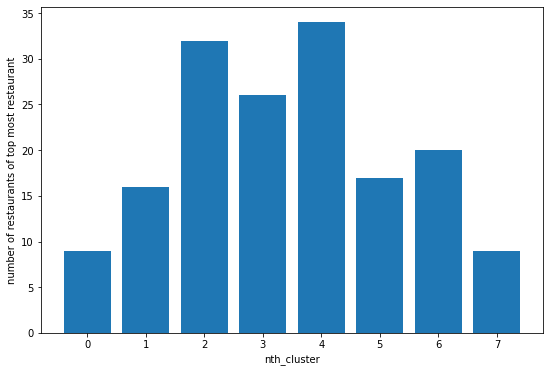

In [139]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
plt.bar(top.cluster,top.number_of_top_restaurants)
plt.xlabel('nth_cluster')
plt.ylabel('number of restaurants of top most restaurant')

# Discussion


lets bring the key analysis of our algorithm
so cluster2 -Italy and in cluster4- chinese traditional food have tremendous data,  this could be because of the prosperity of the region or avaliable of schools,offices where week day work is more. we can see that after italain 

there are very less number of other restaurants
let's also discuss why there are only few restaurants in cluster0 regions, either the foursqure api must have missed data or the service, place might not be confortable or may be taste wasn't good

so can we clearly say we can open a Italian restraunt  or chinese restaurant in corresponding clusters

# Conclusion

Purpose of this project was to analyze the neighborhoods of nyc and create a clustering model to suggest personals places to start a new business based on the category. The neighborhoods data was obtained from an online source and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 10 venues returned. In order to build a good Data Science model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters i.e. 8 was obtained using the silhouette score and I did elbow method to conform it and it worked well . Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.

This project can conclude by providing me a bundle of knowledge based on real life project. The applictions we can hereafter apply in this project will be helpful in any city,place.

The `stakeholder` takeaway of this project will be considering the number of most famous restaurants type in each cluster and proceed to open restaurant choosing profitabel cluster



# Thankyou